In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold

import time

In [2]:
num_classifiers = 5
best_accuracy = np.zeros(num_classifiers)
train_time = np.zeros(num_classifiers)
test_time = np.zeros(num_classifiers)

In [3]:
cars_df = pd.read_csv("data/car_evaluation.csv", names = ["buying","maint", "doors", "persons", "lug_boot","safety","class"])
cars_df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [4]:
cleanup_nums = {"class":     {"unacc": 4, "acc": 3,'good': 2,'vgood':1}
                }
cars_df.replace(cleanup_nums,inplace = True)

In [5]:
target = cars_df['class']

In [6]:
cars_df.drop( ['class'],axis = 1,inplace = True)

In [7]:
cars_df_categorical = pd.get_dummies(cars_df)
cars_df_categorical.head()

,buying_high,buying_low,buying_med,buying_vhigh,maint_high,maint_low,maint_med,maint_vhigh,doors_2,doors_3,...,doors_5more,persons_2,persons_4,persons_more,lug_boot_big,lug_boot_med,lug_boot_small,safety_high,safety_low,safety_med
0,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,0,1,0,1,0
1,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,0,1,0,0,1
2,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,0,1,1,0,0
3,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,1,0,0,1,0
4,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,1,0,0,0,1


In [8]:
X_train,X_test,Y_train,Y_test = train_test_split(cars_df_categorical, target, random_state = 42)

In [9]:
print(len(X_train))
print(len(Y_train))
print(len(X_test))
print(len(Y_test))

1296
1296
432
432


In [10]:
from sklearn import tree
dt_model = tree.DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train,Y_train)
print(dt_model.score(X_train,Y_train))
dt_pred= dt_model.predict(X_test)
print('Misclassified samples using Trees are: %d' %(Y_test!=dt_pred).sum())
print('Classification Accuracy of Decision trees is %.2f ' %accuracy_score(Y_test,dt_pred))

1.0
Misclassified samples using Trees are: 14
Classification Accuracy of Decision trees is 0.97 


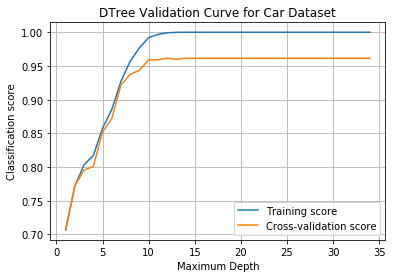

In [11]:
depth_range = np.arange(1,35)
train_scores, test_scores = validation_curve(dt_model, X_train, Y_train, param_name="max_depth", param_range=depth_range, cv=5,
                                            n_jobs=4)

plt.figure()
#plt.xticks(depth_range)
plt.plot(depth_range, np.mean(train_scores, axis=1), label='Training score')
plt.plot(depth_range, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('DTree Validation Curve for Car Dataset')
plt.xlabel('Maximum Depth')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_validation_curve_1.png')
plt.show()

In [12]:
depth_range = np.arange(1,35)
leaf_range = np.arange(1,25)
tuned_params = {'max_depth' : depth_range}
clf_dt = GridSearchCV(dt_model, param_grid=tuned_params, cv=5, n_jobs=4)
t0 = time.time()
clf_dt.fit(X_train, Y_train)
t1 = time.time()
train_time[0] = t1 - t0
print('Completed training in %f seconds' % train_time[0])
best_clf_dt = clf_dt
best_dt_params = clf_dt.best_params_
print("Best parameters set for decision tree found on development set:")
print(best_dt_params)
t0 = time.time()
y_pred = clf_dt.predict(X_test)
t1 = time.time()
test_time[0] = t1 - t0
print('Inference time on test data: %f seconds' % test_time[0])
best_accuracy[0] = accuracy_score(Y_test, y_pred)
print('Accuracy of decision tree is %.2f%%' % (best_accuracy[0] * 100))

from sklearn.metrics import confusion_matrix
print(confusion_matrix(Y_test, y_pred))

Completed training in 0.289653 seconds
Best parameters set for decision tree found on development set:
{'max_depth': 12}
Inference time on test data: 0.000835 seconds
Accuracy of decision tree is 96.99%
[[ 17   2   1   0]
 [  1  14   0   0]
 [  3   4  95   1]
 [  0   0   1 293]]


/anaconda3/envs/mlclass/lib/python3.5/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/anaconda3/envs/mlclass/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/anaconda3/envs/mlclass/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/anaconda3/envs/mlclass/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/anaconda3/envs/mlclass/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:547: UserWar

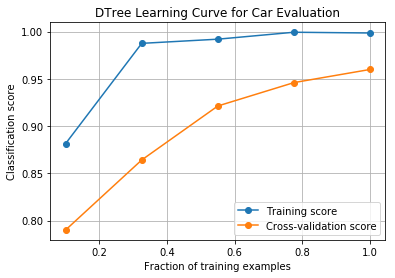

In [14]:
train_sizes = np.linspace(0.1, 1.0, 5)
_, train_scores, test_scores = learning_curve(best_clf_dt, X_train, Y_train, train_sizes=train_sizes, cv=5, n_jobs=4)

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Cross-validation score')
plt.title('DTree Learning Curve for Car Evaluation')
plt.xlabel('Fraction of training examples')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_learning_curve.png')
plt.show()